## MTLR sentiment data parsing and posts filtering

### Module imports

In [2]:
import os, sys, re
from tqdm import tqdm
import sqlite3
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import importlib
import scripts.post_parser

importlib.reload(scripts.post_parser)
print('modules reloaded!')

from scripts.post_parser import TinkoffPulseParser

modules reloaded!


In [3]:
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(current_dir)
database_path = os.path.join(project_root, 'databases', 'mtlr_posts_2023.db')

### T-Pulse posts parsing

In [ ]:
# custom_db = "mtlr_posts_2023.db"
# parser = TinkoffPulseParser(
#     start_date='2023-01-01',
#     db_name=custom_db
# )
# parser.parse_single_ticker("MTLR")

Обрабатывается дата: 2023-01-03T07:48:17.977Z
Получено постов: 178946


2025-03-01 09:41:49,451 - INFO - Достигнута целевая дата 2023-01-01 00:00:00+00:00


### EDA

In [11]:
conn = sqlite3.connect(database_path)
mtlr_posts_2023 = pd.read_sql_query("SELECT * FROM tcs_pulse_posts", conn)

In [7]:
mtlr_posts_2023.head(3)

,id,post_id,inserted,instruments,hashtags,content,reactions_count,comments_count,parse_dt
0,1,986f79ed-7a2a-4028-8d34-52794041a3fa,2025-03-01T10:03:01.236Z,"MTLR, SGZH, MVID, ORUP, AMEZ, ZILLP, OKEY, CAR...",None,Приветствую! Хочу собрать портфель из интересн...,1,6,2025-03-01 13:53:06
1,2,6a69a9af-2234-48a3-a6d6-d2728edd9c28,2025-03-01T09:55:56.767Z,MTLR,None,"{$MTLR} В воскресенье, 2 марта, в Лондоне прой...",0,0,2025-03-01 13:53:06
2,3,1fcfe0dd-4c6f-463e-9630-f17701167f55,2025-03-01T08:57:00.788Z,MTLR,None,{$MTLR} завязал с шортом капитальных должников...,1,0,2025-03-01 13:53:06


Преобразуем дату и посмотрим на динамику публикаций

In [12]:
mtlr_posts_2023['inserted'] = pd.to_datetime(mtlr_posts_2023["inserted"].str[:10])
daily_counts_mltr = mtlr_posts_2023.groupby('inserted').size().reset_index(name='count')

In [13]:
%load_ext autoreload
%autoreload 2
from scripts.vizualizer import plot_daily_posts

plot_daily_posts(daily_counts_mltr, "MTLR")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Сохраним общее число публикаций на каждый день будем использовать как дополнительный признак в модели:

In [14]:
mtlr_posts_2023["total_day_posts_cnt"] = mtlr_posts_2023.groupby(by="inserted")[
    "id"
].transform("count")

Также нам важно понимать распределение длин текстов:

In [15]:
mtlr_posts_2023['words_cnt'] = mtlr_posts_2023['content'].apply(lambda x: len(x.split()))
mtlr_posts_2023['post_len'] = mtlr_posts_2023['content'].apply(len)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


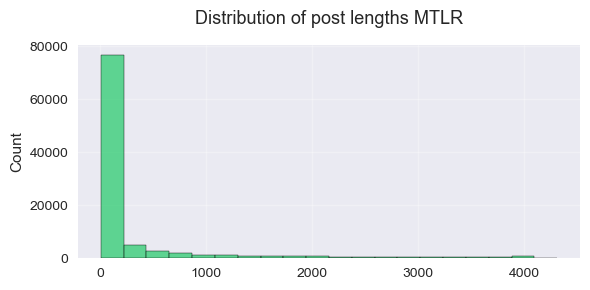

In [16]:
%load_ext autoreload
%autoreload 2
from scripts.vizualizer import plot_posts_length

plot_posts_length(mtlr_posts_2023, 'MTLR', 'post_len', '')

### Content processing

In [17]:
%load_ext autoreload
%autoreload 2
from scripts.post_processer import preprocess_text_base

tqdm.pandas()
mtlr_posts_2023['content_base'] = mtlr_posts_2023['content'].progress_apply(preprocess_text_base)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 97039/97039 [00:01<00:00, 70513.99it/s]


In [ ]:
mtlr_posts_2023["instruments"] = mtlr_posts_2023["instruments"].fillna("error")

mtlr_posts_2023["tags"] = 0
mtlr_posts_2023["tags"] = mtlr_posts_2023["instruments"].apply(
    lambda x: ", ".join(sorted(x.split(", ")))
)

In [19]:
mtlr_posts_2023['tags'].value_counts(normalize=True)

MTLR                                                                           0.816486
MTLR, MTLRP                                                                    0.027154
MTLR, MTLRP, RASP                                                              0.005956
MTLR, RASP                                                                     0.004225
MTLR, SGZH                                                                     0.001247
                                                                                 ...   
AFKS, AFLT, CNYRUB, ENPG, LEAS, MOEX, MTLR, MTLRP, PLZL, SGZH, USDRUB, VKCO    0.000010
DELI, FESH, GMKN, KMAZ, MBNK, MOEX, MTLR, MTSS, PHOR, T, VKCO, VTBR            0.000010
FESH, MTLR, POSI                                                               0.000010
MTLR, RNFT, YDEX                                                               0.000010
CHMF, GAZP, IRAO, MGNT, MOEX, MTLR, PIKK, RUAL, SBER                           0.000010
Name: tags, Length: 10044, dtype

In [24]:
mtlr_posts_2023["mtlr_only"] = mtlr_posts_2023["tags"].apply(
    lambda x: 1 if (x == "MTLR" or x == "MTLR, MTLRP") else 0
)

In [ ]:
ticker = 'MTLR'
mtlr_patterns = [
    r"\{\$MTLR[P]?\}",  # Ticker symbol in posts
]

In [ ]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import preprocess_other_tickets

# 2
tqdm.pandas()
mtlr_posts_2023["processed_posts"] = mtlr_posts_2023.progress_apply(
    lambda df: (
        preprocess_other_tickets(df["content_base"], ticker, mtlr_patterns)
        if df["mtlr_only"] == 0
        else df["content_base"]
    ),
    axis=1,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 97039/97039 [00:05<00:00, 17155.17it/s]


In [26]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import clean_promotional_content

# 3
tqdm.pandas()
mtlr_posts_2023["processed_posts"] = mtlr_posts_2023["processed_posts"].progress_apply(
    lambda x: clean_promotional_content(x)
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 97039/97039 [11:18<00:00, 142.93it/s]


In [27]:
%load_ext autoreload
%autoreload 2

from scripts.post_processer import mark_ticker_only_posts

# 4
mtlr_posts_2023 = mark_ticker_only_posts(mtlr_posts_2023)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 97039/97039 [00:01<00:00, 55468.99it/s]


In [28]:
mtlr_posts_2023['ticker_only'].value_counts()

0    92555
1     4484
Name: ticker_only, dtype: int64

In [29]:
mtlr_posts_processed = mtlr_posts_2023[mtlr_posts_2023['ticker_only'] != 1]

In [30]:
req_cols = [
    "post_id",
    "inserted",
    "tags",
    "hashtags",
    "processed_posts",
    "reactions_count",
    "comments_count",
    "total_day_posts_cnt",
]

mtlr_upload = mtlr_posts_processed[req_cols].reset_index(drop=True)

In [31]:
save_path = os.path.join(project_root, 'processed_data', 'mtlr_processed_full.xlsx')
mtlr_upload.to_excel(save_path, encoding="utf-8", index=False)

Готовим выборку

In [32]:
mtlr_post_id = mtlr_upload[['post_id', 'processed_posts']]

In [33]:
mtlr_train, mtlr_val = mtlr_post_id[3000:], mtlr_post_id[:3000]

mtlr_llm, mtlr_val = mtlr_val[:2500], mtlr_val[2500:]

In [34]:
save_path_train = os.path.join(project_root, 'processed_data', 'mtlr_train.xlsx')
save_path_llm = os.path.join(project_root, 'processed_data', 'mtlr_llm.xlsx')
save_path_val = os.path.join(project_root, 'processed_data', 'mtlr_val.xlsx')

mtlr_train.to_excel(save_path_train, encoding="utf-8", index=False)
mtlr_llm.to_excel(save_path_llm, encoding="utf-8", index=False)
mtlr_val.to_excel(save_path_val, encoding="utf-8", index=False)